In [1]:
import autograd.numpy as np
from autograd import grad

import matplotlib.pyplot as plt

Goal. Learn the transition fn for a complex dynamical system.

A few moving parts. (vaugely inspired by the successor representation)

__Online clustering__ that starts simple and increases the number of clusters.
- Could cluster by reward.
- Want it to be density based!

__Transition approximation__ that can be learned and transferred.
- Given a clustering algol on a dynamical system, learn a simpler transition fn. A reduced representation.
- Given a new clustering, $C_{new}$, which was derived from $C_{old}$. And given $T_{old}$ which learned to capture the dynamics under $C_{old}$, construct $T_{new}$ using the knowledge we have.
    - if a cluster is split in two, then init both with the same transition fns and let them diverge as necessary.
    - if a new cluster overlaps two old ones, then !?!?
    
    
***

Matrices are really nice as they make it easy to transfer the knowledge.
If node/cluster $d$ recieved from $a$ and projected to $e, f$. Then when we init the new clusters, $d_1, d_2$ we can initialise them with the same signature as $d$.

Which other representations make this easy? How can this be done with a neural network?
If $t: S \rightarrow S$ is some transition function, and $t^*$ is our approximation, then how can we transfer knowledge in the NN to ...?

***

$$
y(t) = f(y_t-1, dy_t-1, ...?)
$$

$$

$$

In [323]:
class DynamicalSystem():
    """
    Want something related to DFAs.
    
    For now, just binarise the states.
    
    TODO;
    - generate non linear systems
    - find a nice system, a complex graph or something, with meaningful nodes
    - ?
    """
    smap = {0:' ', 1:'.'}
    
    def __init__(self, n):
        self.n = n

        
        self.state = np.zeros(n)
        self.state[np.random.randint(0, self.n)] = 1
        
        # could make a sparse matrix to be more efficient?
        self.G = np.random.randint(-2, 2, (n, n))
        self.G = (0.5/(n**2)*(np.random.standard_normal((n, n)) > 1).astype(np.int32) 
                  - 0.5/(n**2)*(np.random.standard_normal((n, n)) > 1).astype(np.int32))
        
    @staticmethod
    def tostring(x):
        return ''.join([DFA.smap[s] for s in x])
        
    def __repr__(self):
        return self.tostring(self.state)
    
    def step(self):
        self.state = (np.dot(self.G, self.state) > 0).astype(np.int32)
        
    def reset(self):
        self.state = np.zeros(self.n)
        self.state[np.random.randint(0, self.n)] = 1
        
    def show(self):
        plt.imshow(self.G, interpolation='nearest', cmap='gray')
        
        
class Encoder():
    """
    Want to learn this encoder, but for now, just use rnd projection.
    
    TODO;
    - learn online
    - look into neural discrete representations 
    (could be as simple as just adding a new vector to memory?)
    https://gist.github.com/act65/edf2627b42ee570fe2ea36d8e33f7b88
    https://deepmind.com/research/publications/neural-discrete-representation-learning/
    - 
    """
    def __init__(self, n, d):
        self.n = n
        self.d = d
        self.proj = np.random.standard_normal((d, n))
    
    def __call__(self, x):
        return (np.dot(self.proj, x).T > 0).astype(np.int32)
    
    def add_cluster(self):
        self.proj = np.vstack([self.proj, np.random.standard_normal((1, self.n))])

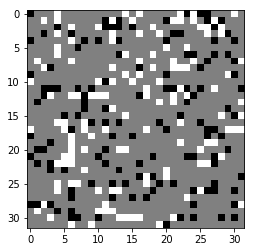

In [324]:
n = 32
d = 12
ds = DFA(n)
ds.show()

enc = Encoder(n, d)

In [325]:
dfa.reset()
for i in range(10):
    print(dfa, '---', dfa.tostring(enc(dfa.state)))
    dfa.step()

      .                          ---  . ....... .
  . .  .    .     .....  .     . ---  ...... . ..
..   .... . ...    .  ..  . .    --- ...... .. ..
  ..   .. . .   .. .. .   .  . . --- . .. ..   ..
....   .... ..  .. .   .  . ..   --- . .. .  . ..
  ..   .... .    .        .  . . --- . .  .  . ..
 ..     ... .    .        . .. . --- . .  .  . . 
  ..   .... .  . . .   .  . .. . ---   ....  .   
 ...    ... .  . .        . .. . ---   .  .  . . 
 ...   .... .  . .        .  . . --- . .  .  . ..


In [326]:
enc.add_cluster()
dfa.reset()
for i in range(10):
    print(dfa, '---', dfa.tostring(enc(dfa.state)))
    dfa.step()

          .                       --- .. ... .  .  
  .       . .             .  .    --- . .. .. .   .
 ..     ...        .  .   . ..    --- . .  .  . .  
  .     ...      . .   .     . .  ---   . ..  .    
 ..  . .... .  . ..    .  . .. .  --- . .  .  . . .
 ...   .... .   .. .  .     .. .  --- . .  .  . ...
....   .... .    .        .  . .  ---   . ..  . .. 
 ..    .. . .    .        .  . .  --- . .  .  . .. 
 ..    .... .   .. .   . .. ..    --- . .  .. . .. 
  ..   .... .    . .   .  .  . .  --- . .. .  . .  


In [327]:
class Approximator():
    """
    
    TODO;
    - need a way to transfer knowledge given knowledge about where to transfer
    - want a more powerful representation (non linear fn approximator)
    - ?
    """
    def __init__(self, n, approx=None):
        self.n = n
        self.W = np.random.standard_normal((n, n))
        self.dL = grad(self.loss)
        
    @staticmethod
    def loss(W, x, t):
        # this doesnt seem fair. the dfa uses a different fn to generate the seq
        y = np.dot(W, x)  
        return np.sum((t-y)**2)
    
    def __call__(self, x):  
        return (np.dot(self.W, x) > 0.5).astype(np.int32)
        
    def train(self, x, t):
        self.W -= 0.001 * self.dL(self.W, x, t)

In [328]:
app = Approximator(3)
x = np.random.random((3, 1))
t = np.random.random((3, 1))
app.train(x, t)

In [329]:
n = 128
d = 16
dfa = DFA(n)
enc = Encoder(n, d)
app = Approximator(d)

In [330]:
def train(dfa, enc, app, epochs=500):

    for e in range(epochs):
        dfa.reset()
        old_obs = enc(dfa.state)
        for i in range(20):
            dfa.step()
            obs = enc(dfa.state)
            app.train(old_obs, obs)

            loss = app.loss(app.W, old_obs, obs)
    #         loss = np.linalg.norm(app.W-dfa.G)
            print('\rloss: {}'.format(loss), end='', flush=True)
            old_obs = obs
    return app
            
app = train(dfa, enc, app)

loss: 4.386233162502998

In [176]:
# want batch training!?
# online training is unnecessarily complicating things?
def run(dfa, n):
    for i in range(20):
        dfa.step()
        obs = enc(dfa.state)
    return np.array([dfa.step()])



In [343]:
dfa.reset()
for i in range(10):
    c = enc(dfa.state)
    y = app(c)
    dfa.step()
    print(dfa.tostring(c), '---', dfa.tostring(y))

.   ....  ... ..  --- ......... ......
     ....  . .    ---     .  ..       
    .. .....  ..  --- ..  .  .. .  ...
.   .. .. .. . .  --- ..  .  .. .. ...
 .    ... .. .    ---  .  .  .. .    .
 .   . .  ..  ..  --- ..  .  .. ..  ..
 .  .. .. ..  ..  --- ..  .  .. .. ...
.   .  .  .   .   ---  .        .   ..
 .       ... ..   --- ..     .  .   . 
...    .  ..  .   ---  .     .. ..  ..


In [ ]:
enc.add_cluster()
app = Approximator.transfer(old_enc, new_enc, app)  # construct new approx. how!?
app = train(dfa, enc, app)